In [0]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
from operator import attrgetter
import timeit
import seaborn as sns

In [0]:
nsensors = 10
ntimestamps = 1000
resample_interval = 10
interval_from = '2021-01-01 00:00:00'
interval_to = '2021-01-07 00:00:00'

# Create test data

In [0]:
# Per sensor create ntimestamps random time values between interval_from and interval_to
# Take a sinus based function to calculate a value (take different magnitude and period per sensor)
df_sensors = spark.range(nsensors).selectExpr('id+1 as SensorId')
df_time = spark.range(ntimestamps).selectExpr('id as Range')
df_test = (df_sensors.join(df_time, how='full')
           .withColumn('UnixTimestamp', F.expr(f"round(rand()*(unix_timestamp('{interval_to}')-unix_timestamp('{interval_from}'))+unix_timestamp('{interval_from}'))"))
           .withColumn('Timestamp', F.expr("to_timestamp(UnixTimestamp)"))
           .withColumn('Value', F.expr(f"SensorId * sin(2*3.14/SensorId*(UnixTimestamp - unix_timestamp('{interval_from}'))/(unix_timestamp('{interval_to}')-unix_timestamp('{interval_from}')))"))
           .drop('UnixTimestamp')
           .drop('Range')
           # Make sure no duplicate rows
           .dropDuplicates(['SensorId', 'Timestamp'])
          )

In [0]:
df_test.persist()

Out[4]: DataFrame[SensorId: bigint, Timestamp: timestamp, Value: double]

In [0]:
df_test.count()

Out[5]: 9986

# Resample + interpolate pyspark

In [0]:
def interpolate_pyspark(resample_interval):
  df_pyspark = (
        df_test
        # Get timestamp and value of previous measurement
        .selectExpr(
          "SensorId",
          "LAG(Timestamp) OVER (PARTITION BY SensorId ORDER BY Timestamp ASC) as PreviousTimestamp",
          "Timestamp as NextTimestamp",
          "LAG(Value) OVER (PARTITION BY SensorId ORDER BY Timestamp ASC) as PreviousValue",
          "Value as NextValue",
        )
        # To determine resample interval round up start and round down end timeinterval to nearest interval boundary
        .withColumn("PreviousTimestampRoundUp", F.expr(f"to_timestamp(ceil(unix_timestamp(PreviousTimestamp)/{resample_interval})*{resample_interval})"))
        .withColumn("NextTimestampRoundDown", F.expr(f"to_timestamp(floor(unix_timestamp(NextTimestamp)/{resample_interval})*{resample_interval})"))
        # Make sure we don't get any negative intervals (whole interval is within resample interval)
        .filter("PreviousTimestampRoundUp<=NextTimestampRoundDown")
        # Create resampled time axis by creating all "interval" timestamps between previous and next timestamp
        .withColumn("Timestamp", F.expr(f"explode(sequence(PreviousTimestampRoundUp, NextTimestampRoundDown, interval {resample_interval} second)) as Timestamp"))
        # Interpolate value between previous and next
        .selectExpr(
          "SensorId",
          "Timestamp", 
          """(unix_timestamp(Timestamp)-unix_timestamp(PreviousTimestamp))
              /(unix_timestamp(NextTimestamp)-unix_timestamp(PreviousTimestamp))
              *(NextValue-PreviousValue) 
              +PreviousValue
              as Value"""
        )
  )
  df_pyspark.count()

# Resample + interpolate pandasUDF
[source](https://www.learntospark.com/2020/01/interpolation-using-apache-spark.html)

In [0]:
# Define pandas UDF
def resample(schema, freq, timestamp_col = "datetime",**kwargs):
    @F.pandas_udf(
        T.StructType(sorted(schema, key=attrgetter("name"))), 
        F.PandasUDFType.GROUPED_MAP)
    def _(pdf):
        pdf.set_index(timestamp_col, inplace=True)
        pdf=pdf.resample(freq).interpolate()
        pdf.ffill(inplace=True)
        pdf.reset_index(drop=False, inplace=True)
        pdf.sort_index(axis=1, inplace=True)
        return pdf
    return _


In [0]:
def interpolate_pandasudf(resample_interval):
  df_pandasudf = df_test.groupBy("SensorId").apply(resample(df_test.schema, f"{resample_interval}S", timestamp_col='Timestamp'))
  df_pandasudf.count()

# Resample + interpolate python UDF
[source](https://walkenho.github.io/interpolating-time-series-p2-spark/)

In [0]:
df_test_python = (df_test.withColumn('Timestamp', F.expr('cast(Timestamp as int)'))
                  .withColumn('readtime_existent', F.col('Timestamp'))
                 )

In [0]:
def interpolate_pythonudf(resample_interval):

  # define function to create date range
  def date_range(t1, t2, step=resample_interval):
      """Return a list of equally spaced points between t1 and t2 with stepsize step."""
      return [t1 + step*x for x in range(int((t2-t1)/step)+1)]

  # define udf
  date_range_udf = F.udf(date_range, T.ArrayType(T.LongType()))

  # obtain min and max of time period for each house
  df_base = df_test_python.groupBy('SensorId')\
              .agg(F.min('Timestamp').cast('integer').alias('readtime_min'), 
                   F.max('Timestamp').cast('integer').alias('readtime_max'))

  # generate timegrid and explode
  df_base = df_base.withColumn("Timestamp", F.explode(date_range_udf("readtime_min", "readtime_max")))\
               .drop('readtime_min', 'readtime_max')

  # left outer join existing read values
  df_all_dates = df_base.join(df_test_python, ["SensorId", "Timestamp"], "fullouter")

  from pyspark.sql import Window
  import sys

  window_ff = Window.partitionBy('SensorId')\
                 .orderBy('Timestamp')\
                 .rowsBetween(-sys.maxsize, 0)

  window_bf = Window.partitionBy('SensorId')\
                 .orderBy('Timestamp')\
                 .rowsBetween(0, sys.maxsize)

  # create the series containing the filled values
  read_last = F.last(df_all_dates['Value'], ignorenulls=True).over(window_ff)
  readtime_last = F.last(df_all_dates['readtime_existent'], ignorenulls=True).over(window_ff)

  read_next = F.first(df_all_dates['Value'], ignorenulls=True).over(window_bf)
  readtime_next = F.first(df_all_dates['readtime_existent'], ignorenulls=True).over(window_bf)

  # add the columns to the dataframe
  df_filled = df_all_dates.withColumn('readvalue_ff', read_last)\
                          .withColumn('readtime_ff', readtime_last)\
                          .withColumn('readvalue_bf', read_next)\
                          .withColumn('readtime_bf', readtime_next)

  # define interpolation function
  def interpol(x, x_prev, x_next, y_prev, y_next, y):
      if x_prev == x_next:
          return y
      else:
          m = (y_next-y_prev)/(x_next-x_prev)
          y_interpol = y_prev + m * (x - x_prev)
          return y_interpol

  # convert function to udf
  interpol_udf = F.udf(interpol, T.FloatType())   

  # add interpolated columns to dataframe and clean up
  df_filled = df_filled.withColumn('readvalue_interpol', interpol_udf('Timestamp', 'readtime_ff', 'readtime_bf', 'readvalue_ff', 'readvalue_bf', 'Value'))\
                      .drop('readtime_existent', 'readtime_ff', 'readtime_bf')\
                      .withColumnRenamed('reads_all', 'readvalue')\
                      .withColumn('Timestamp', F.from_unixtime(F.col('Timestamp')))
  df_filled.count()


# generate plots

In [0]:
df_results = pd.DataFrame([{'function':f.__name__, 'interval_size':s, 'duration':timeit.timeit('f(s)', globals={'f':f,'s':s}, number=1)} for s in [60*60, 10*60, 60, 10, 1] for f in [interpolate_pyspark, interpolate_pandasudf, interpolate_pythonudf]])

/databricks/spark/python/pyspark/sql/pandas/group_ops.py:76: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
 "more details.", UserWarning)

In [0]:
df_results

Out[12]:

,function,interval_size,duration
0,interpolate_pyspark,3600,2.767818
1,interpolate_pandasudf,3600,3.195723
2,interpolate_pythonudf,3600,4.058001
3,interpolate_pyspark,600,1.309582
4,interpolate_pandasudf,600,1.213673
5,interpolate_pythonudf,600,3.261308
6,interpolate_pyspark,60,1.422059
7,interpolate_pandasudf,60,1.426586
8,interpolate_pythonudf,60,3.026001
9,interpolate_pyspark,10,1.194893


Out[13]:

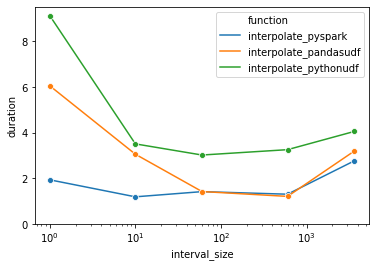

[(0, 9.526644894999867)]

In [0]:
grid = sns.lineplot(data=df_results, x="interval_size", y="duration", hue='function', markers='true', marker="o")
grid.set(xscale="log")
grid.set(ylim=(0, None))